<a href="https://colab.research.google.com/github/KeyboarderSon/TIL/blob/main/RNN/RNN_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

original dataset shape :  (732, 5)
[[0.24271481 0.23486317 0.18737251 0.36110962 0.17039458]
 [0.13075879 0.14979736 0.13950917 0.35107108 0.1339569 ]
 [0.15042457 0.16374824 0.15035617 0.23008873 0.14071632]
 [0.14549092 0.14452321 0.11061926 0.34481491 0.154517  ]
 [0.16681257 0.20764196 0.18773052 0.4378686  0.22527992]
 [0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]] -> [0.14877846]
_x의 shape :  (7, 5) _y의 shape :  (1,)
dataX의 shape :  (505, 7, 5) dataY의 shape :  (505, 1)
[[0.46855688 0.48381966 0.49057346 0.20893047 0.49853637]
 [0.4976321  0.50109047 0.54172895 0.10236866 0.50737719]
 [0.49745208 0.52284114 0.54166203 0.22797667 0.54202261]
 [0.53629892 0.56439721 0.56956613 0.18077117 0.58747978]
 [0.59055219 0.57530222 0.52128258 0.26919995 0.51173763]
 [0.52155147 0.50593586 0.52540211 0.17577666 0.50421114]
 [0.50584501 0.51959924 0.52261521 0.46115284 0.54285897]] -> [0.30171446]
_x의 shape :  (7, 5) _y의 shap

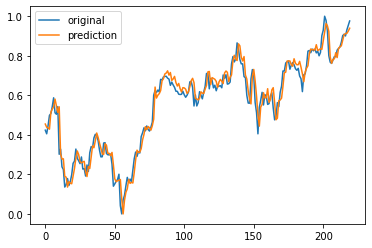

In [8]:
#https://github.com/deeplearningzerotoall/PyTorch/blob/master/RNN/5-timeseries.py

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)


# nomalize : (x-min)/(max-min)
# return shape : (batch size, dimension)
# 불러오는 original dataset의 shape은 (732, 5) 이다.
# min(data, 0)은 axis가 0이라는 것인데 행의 같은 idx를 그룹화하여(=열로 보면 될듯) 그로부터 최솟값을 뽑아낸다.
# 여기에 적용하면 각 카테고리별 최솟값을 리턴한다.
def minmax_scaler(data):
  numerator=data-np.min(data, 0)
  denominator=np.max(data,0)-np.min(data,0)
  #noise term prevents the zero division
  return numerator / (denominator +1e-7)

def build_dataset(time_series, seq_length):
  dataX=[]
  dataY=[]
  for i in range(0, len(time_series)-seq_length):
    _x=time_series[i:i+seq_length,:]
    _y=time_series[i+seq_length, [-1]] # Next close price
    if i==10:
      print(_x,"->", _y)
      print("_x의 shape : ",_x.shape, "_y의 shape : ", _y.shape)
    dataX.append(_x)
    dataY.append(_y)
  print("dataX의 shape : ", np.array(dataX).shape, "dataY의 shape : ", np.array(dataY).shape)
  return np.array(dataX), np.array(dataY)


seq_length = 7 # 7 days
data_dim = 5 # 5 category(open, high, low, volume, close)
hidden_dim = 10 # 사용자 마음대로
output_dim = 1 # 8일째의 예측값 하나를 원하는 것
learning_rate = 0.01
iterations = 500

# 시간순으로 만들어주기 위해 순서를 reverse한다
xy = np.loadtxt("https://raw.githubusercontent.com/hunkim/DeepLearningZeroToAll/master/data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1] # reverse order
print("original dataset shape : ", xy.shape)

# data를 train, test 용으로 나눈다.
train_size=int(len(xy)*0.7)
train_set=xy[0:train_size]
test_set=xy[train_size-seq_length:]

#normalize
train_set=minmax_scaler(train_set)
test_set=minmax_scaler(test_set)

trainX, trainY=build_dataset(train_set, seq_length)
testX, testY=build_dataset(test_set, seq_length)

trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)
testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)


class Net(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(Net, self).__init__()
    self.rnn=torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
    self.fc=torch.nn.Linear(hidden_dim, output_dim, bias=True)

  def forward(self, x):
    x, _status=self.rnn(x)
    x= self.fc(x[:, -1])
    return x




net = Net(data_dim, hidden_dim, output_dim, 1)

criterion=torch.nn.MSELoss()
optimizer=optim.Adam(net.parameters(), learning_rate)





for i in range(iterations):
  optimizer.zero_grad()
  outputs = net(trainX_tensor)
  loss=criterion(outputs, trainY_tensor)
  loss.backward()
  optimizer.step()
  if i%20==0:
    print(i, loss.item())


plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()